# Phase Coherence Analysis

Investigating phase-related issues that could affect DOA estimation:
- Sample timing offsets between channels
- Phase drift over time
- Phase jumps/discontinuities
- Sample skipping causing accumulated phase errors
- Channel synchronization issues

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import correlate, correlation_lags
from scipy.stats import linregress
import os
from glob import glob

# Import shared constants
from constants import CHANNEL_ORDER, RADIUS, FREQ, WAVELENGTH, C, DATA_DIR

plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 11

print("Setup complete!")
print(f"Using channel order: {CHANNEL_ORDER}")

Setup complete!
Using channel order: [2, 3, 0, 1]


In [2]:
def load_cs16(filepath):
    """Load a .cs16 file and return complex IQ samples."""
    raw = np.fromfile(filepath, dtype=np.int16)
    iq = raw[0::2] + 1j * raw[1::2]
    return iq

def load_measurement(base_dir, angle, channel_order=None):
    """Load all 4 channels for a given angle measurement.
    
    Args:
        base_dir: Base data directory
        angle: Measurement angle in degrees
        channel_order: List specifying channel reordering. If None, uses CHANNEL_ORDER from constants.
    """
    if channel_order is None:
        channel_order = CHANNEL_ORDER
        
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    
    raw_data = np.vstack(channels)
    return raw_data[channel_order]

# Data directory (from constants.py)
DATA_PATH = f"../data/{DATA_DIR}"

X = load_measurement(DATA_PATH, 45)
print(f"Loaded shape: {X.shape}")
print(f"Channel order: {CHANNEL_ORDER}")

Loaded shape: (4, 2097152)
Channel order: [2, 3, 0, 1]


## 1. Cross-Correlation to Detect Sample Offsets

If channels have sample timing offsets, cross-correlation peak won't be at lag 0.

SAMPLE OFFSET DETECTION (Cross-Correlation)

Peak lag indicates sample offset between channels:
  Positive lag: Ch_j is delayed relative to Ch_i
  Negative lag: Ch_j is ahead of Ch_i
------------------------------------------------------------
  Ch0 vs Ch1:  +0 samples ✓
  Ch0 vs Ch2:  +0 samples ✓
  Ch0 vs Ch3:  -1 samples ⚠️
  Ch1 vs Ch2:  -1 samples ⚠️
  Ch1 vs Ch3:  +4 samples ⚠️
  Ch2 vs Ch3:  -1 samples ⚠️


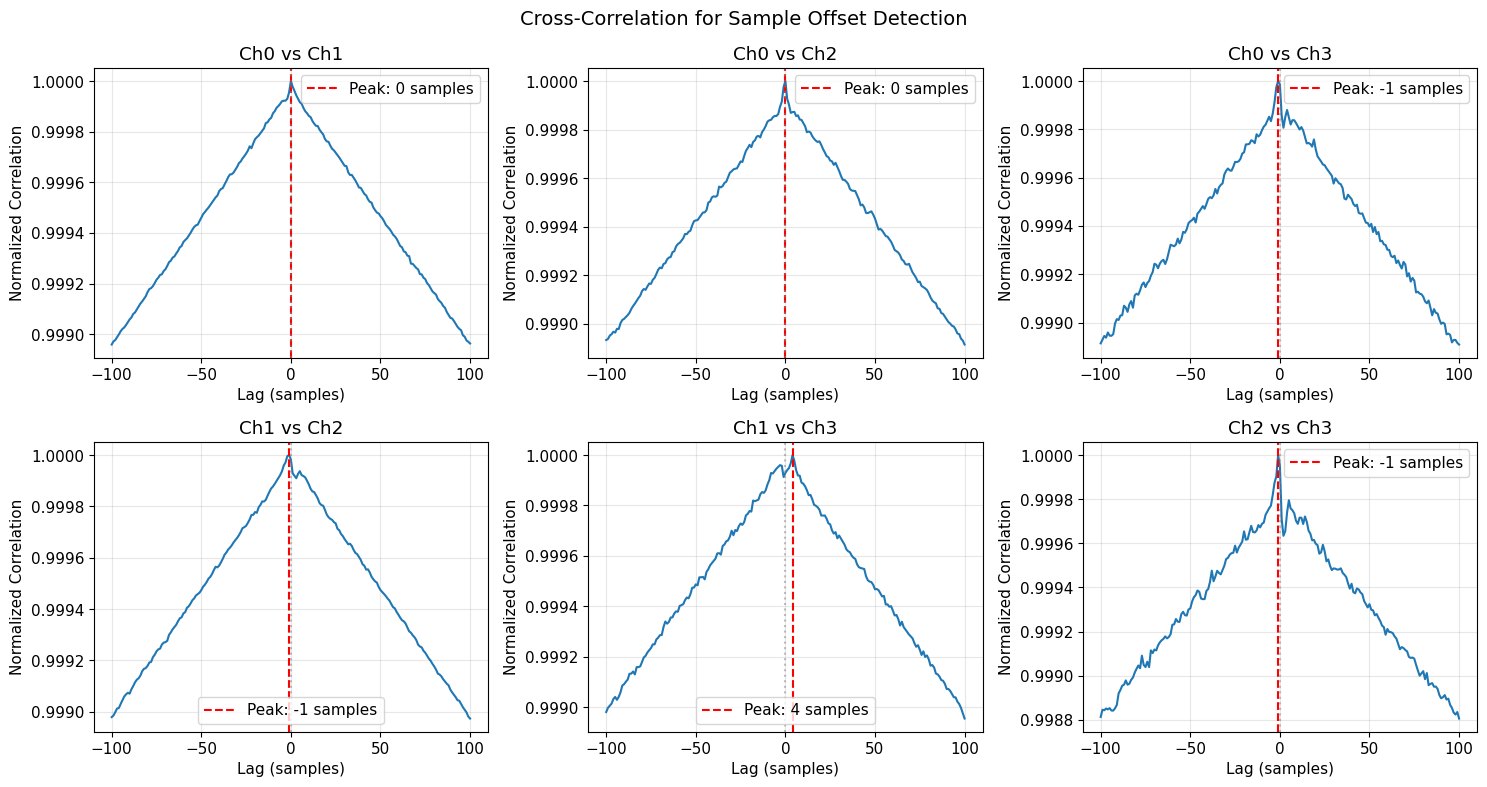

In [3]:
def find_sample_offset(sig1, sig2, max_lag=100):
    """Find sample offset between two signals using cross-correlation."""
    # Use a segment for speed
    n = min(100000, len(sig1))
    s1, s2 = sig1[:n], sig2[:n]
    
    # Cross-correlate
    corr = correlate(s1, s2, mode='full')
    lags = correlation_lags(len(s1), len(s2), mode='full')
    
    # Focus on small lags
    mask = np.abs(lags) <= max_lag
    corr_small = np.abs(corr[mask])
    lags_small = lags[mask]
    
    peak_idx = np.argmax(corr_small)
    peak_lag = lags_small[peak_idx]
    
    return peak_lag, lags_small, corr_small

# Check sample offsets between all channel pairs
print("="*60)
print("SAMPLE OFFSET DETECTION (Cross-Correlation)")
print("="*60)
print("\nPeak lag indicates sample offset between channels:")
print("  Positive lag: Ch_j is delayed relative to Ch_i")
print("  Negative lag: Ch_j is ahead of Ch_i")
print("-"*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
offsets = {}

for idx, (i, j) in enumerate(pairs):
    lag, lags, corr = find_sample_offset(X[i], X[j])
    offsets[(i, j)] = lag
    
    ax = axes[idx]
    ax.plot(lags, np.abs(corr) / np.max(np.abs(corr)))
    ax.axvline(lag, color='r', linestyle='--', label=f'Peak: {lag} samples')
    ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Lag (samples)')
    ax.set_ylabel('Normalized Correlation')
    ax.set_title(f'Ch{i} vs Ch{j}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    status = "✓" if lag == 0 else "⚠️"
    print(f"  Ch{i} vs Ch{j}: {lag:+3d} samples {status}")

plt.suptitle('Cross-Correlation for Sample Offset Detection', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Phase Drift Over Time

Check if phase differences between channels drift over time (indicates clock/timing issues).

In [4]:
def extract_tone_phase_evolution(X, fft_size=4096, hop=2048):
    """
    Extract phase at the tone frequency over time using STFT.
    Returns time axis and phase for each channel.
    """
    n_channels, n_samples = X.shape
    
    # Find tone bin
    fft_full = fft(X[0, :fft_size*4])
    peak_bin = np.argmax(np.abs(fft_full[1:len(fft_full)//2])) + 1
    tone_bin = int(peak_bin * fft_size / (fft_size * 4))
    
    phases = []
    times = []
    
    for start in range(0, n_samples - fft_size, hop):
        segment = X[:, start:start + fft_size]
        fft_seg = fft(segment, axis=1)
        phase = np.angle(fft_seg[:, tone_bin])
        phases.append(phase)
        times.append(start + fft_size // 2)
    
    return np.array(times), np.array(phases).T  # (n_channels, n_times)

times, phases = extract_tone_phase_evolution(X)
print(f"Extracted {len(times)} time points")

Extracted 1022 time points



PHASE DRIFT ANALYSIS
  Ch1 - Ch0: -21.77 °/Msamp (R²=0.0233) ⚠️
  Ch2 - Ch0: +201.01 °/Msamp (R²=0.4798) ⚠️
  Ch3 - Ch0: +201.05 °/Msamp (R²=0.4797) ⚠️


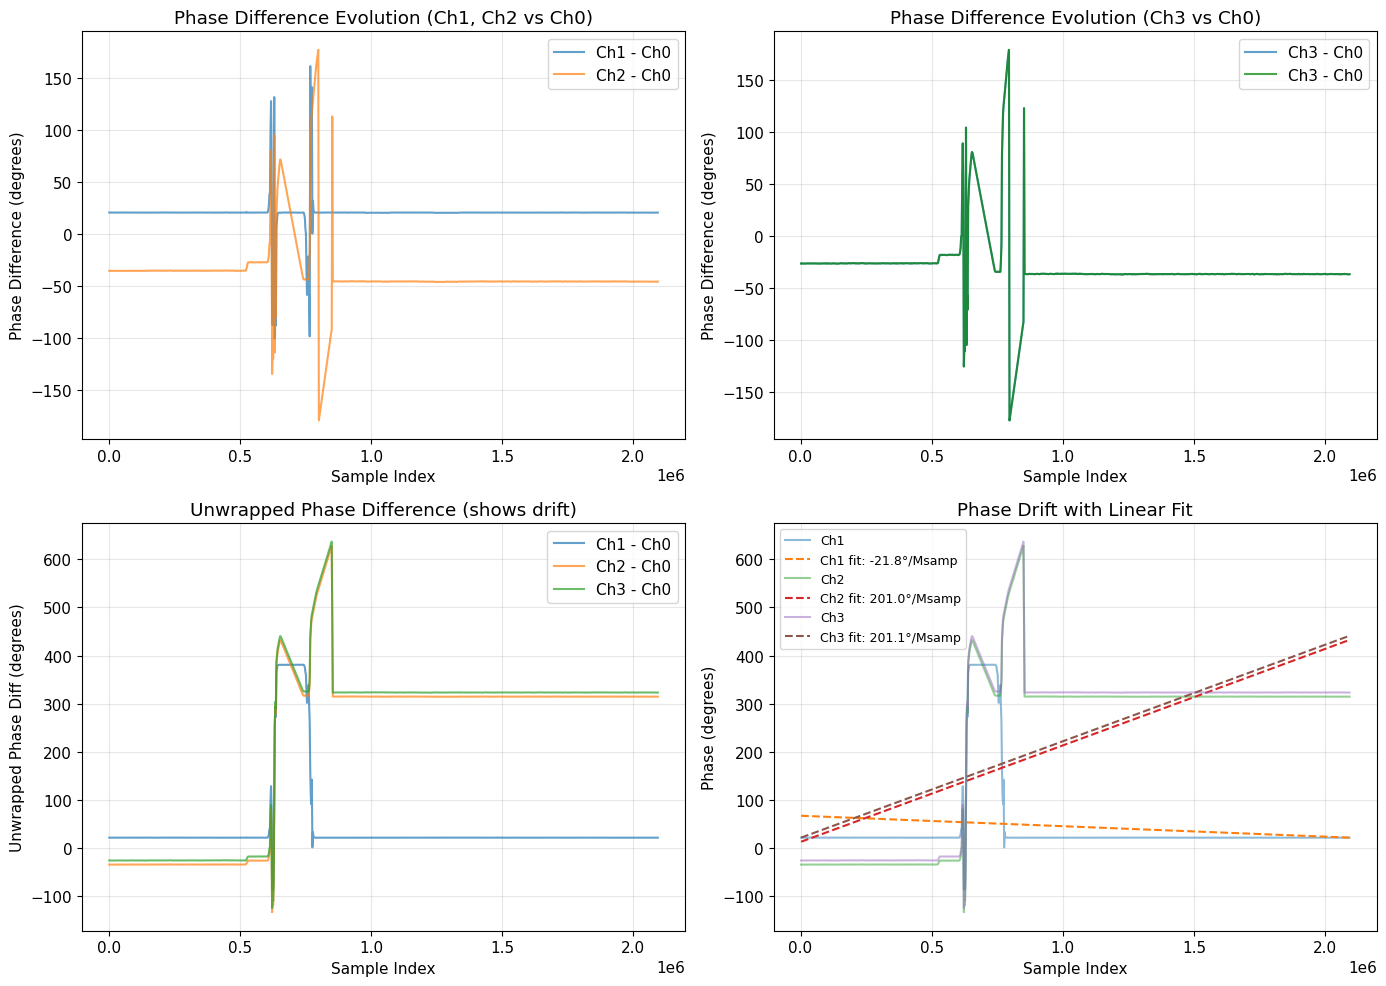

In [5]:
# Compute phase differences relative to channel 0
phase_diffs = phases - phases[0]  # (n_channels, n_times)
phase_diffs = np.angle(np.exp(1j * phase_diffs))  # Wrap to [-pi, pi]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot phase difference evolution
for ch in range(1, 4):
    ax = axes[0, 0] if ch < 3 else axes[0, 1]
    ax.plot(times, np.rad2deg(phase_diffs[ch]), alpha=0.7, label=f'Ch{ch} - Ch0')

axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Phase Difference (degrees)')
axes[0, 0].set_title('Phase Difference Evolution (Ch1, Ch2 vs Ch0)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(times, np.rad2deg(phase_diffs[3]), alpha=0.7, label='Ch3 - Ch0', color='green')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Phase Difference (degrees)')
axes[0, 1].set_title('Phase Difference Evolution (Ch3 vs Ch0)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Unwrap and check for drift
ax = axes[1, 0]
for ch in range(1, 4):
    unwrapped = np.unwrap(phase_diffs[ch])
    ax.plot(times, np.rad2deg(unwrapped), alpha=0.7, label=f'Ch{ch} - Ch0')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Unwrapped Phase Diff (degrees)')
ax.set_title('Unwrapped Phase Difference (shows drift)')
ax.legend()
ax.grid(True, alpha=0.3)

# Linear regression to quantify drift rate
ax = axes[1, 1]
print("\n" + "="*60)
print("PHASE DRIFT ANALYSIS")
print("="*60)

for ch in range(1, 4):
    unwrapped = np.unwrap(phase_diffs[ch])
    slope, intercept, r, p, se = linregress(times, unwrapped)
    
    # Slope in degrees per million samples
    drift_rate = np.rad2deg(slope) * 1e6
    
    ax.plot(times, np.rad2deg(unwrapped), alpha=0.5, label=f'Ch{ch}')
    ax.plot(times, np.rad2deg(intercept + slope * times), '--', 
            label=f'Ch{ch} fit: {drift_rate:.1f}°/Msamp')
    
    status = "✓" if abs(drift_rate) < 10 else "⚠️"
    print(f"  Ch{ch} - Ch0: {drift_rate:+.2f} °/Msamp (R²={r**2:.4f}) {status}")

ax.set_xlabel('Sample Index')
ax.set_ylabel('Phase (degrees)')
ax.set_title('Phase Drift with Linear Fit')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Phase Jumps / Discontinuities

Detect sudden phase jumps that could indicate sample drops or buffer issues.


PHASE JUMP DETECTION
  Ch1 - Ch0: ⚠️ 22 jumps
  Ch2 - Ch0: ⚠️ 14 jumps
  Ch3 - Ch0: ⚠️ 14 jumps


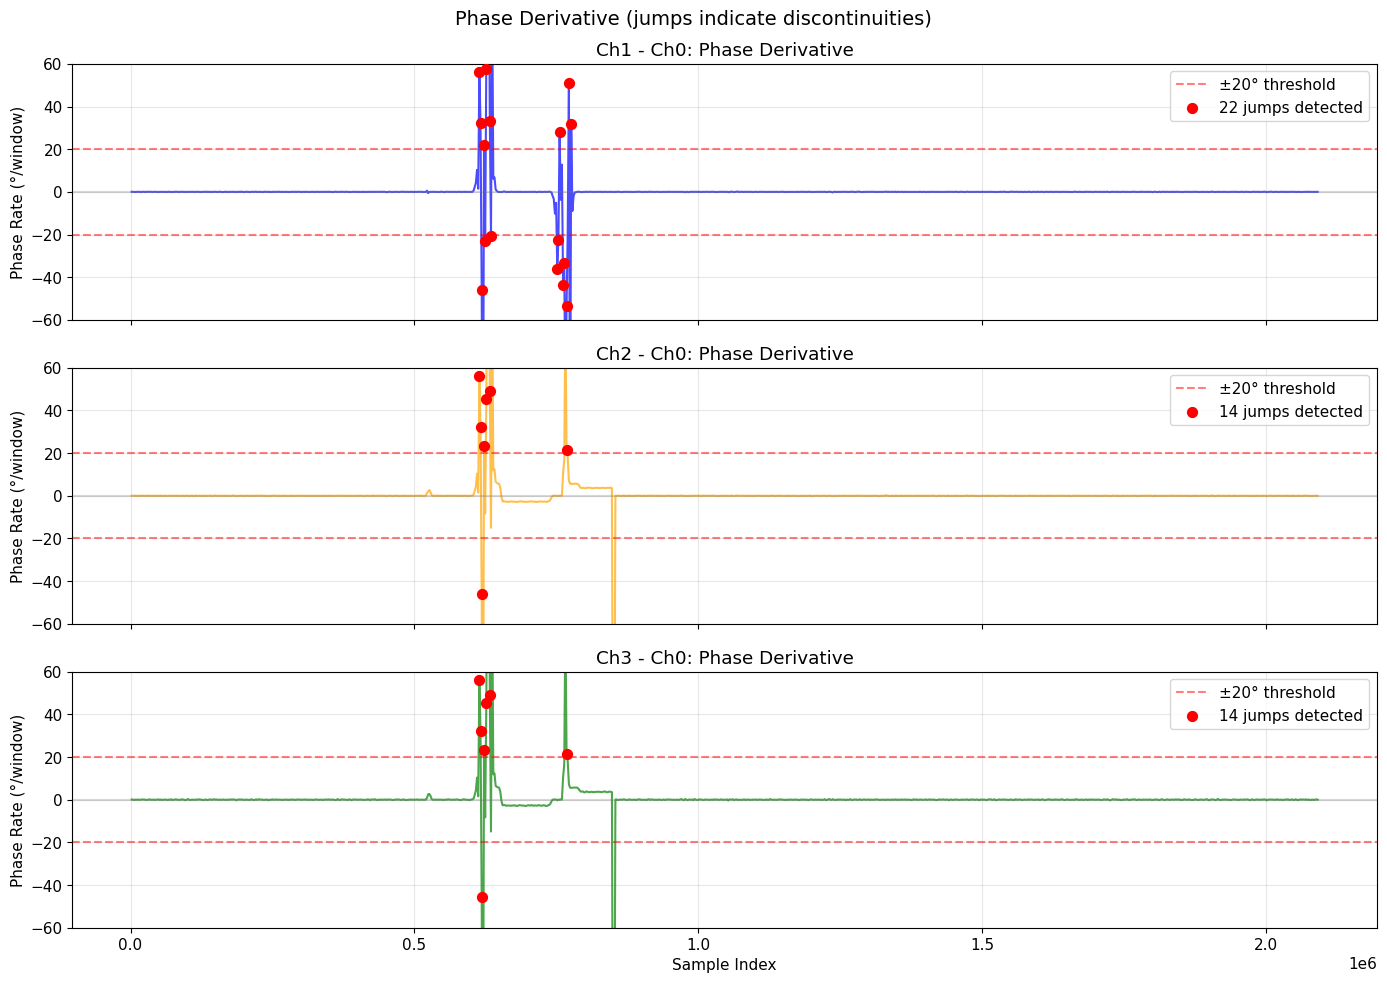

In [6]:
def detect_phase_jumps(phase_diff, threshold_deg=30):
    """
    Detect sudden phase jumps in the phase difference signal.
    """
    # Compute derivative of unwrapped phase
    unwrapped = np.unwrap(phase_diff)
    derivative = np.diff(unwrapped)
    derivative_deg = np.rad2deg(derivative)
    
    # Find jumps exceeding threshold
    jumps = np.where(np.abs(derivative_deg) > threshold_deg)[0]
    
    return jumps, derivative_deg

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

print("\n" + "="*60)
print("PHASE JUMP DETECTION")
print("="*60)

colors = ['blue', 'orange', 'green']
for ch in range(1, 4):
    jumps, deriv = detect_phase_jumps(phase_diffs[ch], threshold_deg=20)
    
    ax = axes[ch-1]
    ax.plot(times[:-1], deriv, alpha=0.7, color=colors[ch-1])
    ax.axhline(20, color='red', linestyle='--', alpha=0.5, label='±20° threshold')
    ax.axhline(-20, color='red', linestyle='--', alpha=0.5)
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
    
    if len(jumps) > 0:
        ax.scatter(times[jumps], deriv[jumps], color='red', s=50, zorder=5, 
                   label=f'{len(jumps)} jumps detected')
    
    ax.set_ylabel('Phase Rate (°/window)')
    ax.set_title(f'Ch{ch} - Ch0: Phase Derivative')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-60, 60)
    
    status = "✓" if len(jumps) == 0 else f"⚠️ {len(jumps)} jumps"
    print(f"  Ch{ch} - Ch0: {status}")
    if len(jumps) > 0 and len(jumps) <= 10:
        print(f"    Jump locations: {times[jumps][:10].tolist()}")

axes[-1].set_xlabel('Sample Index')
plt.suptitle('Phase Derivative (jumps indicate discontinuities)', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Instantaneous Frequency Offset

If channels have slight frequency offsets, phase will drift linearly.


FREQUENCY OFFSET ESTIMATION

Frequency offset between channels (indicates clock mismatch):
  Ch0 vs Ch1: 0.000000 cycles/sample
  Ch0 vs Ch2: -0.000000 cycles/sample
  Ch0 vs Ch3: -0.000000 cycles/sample


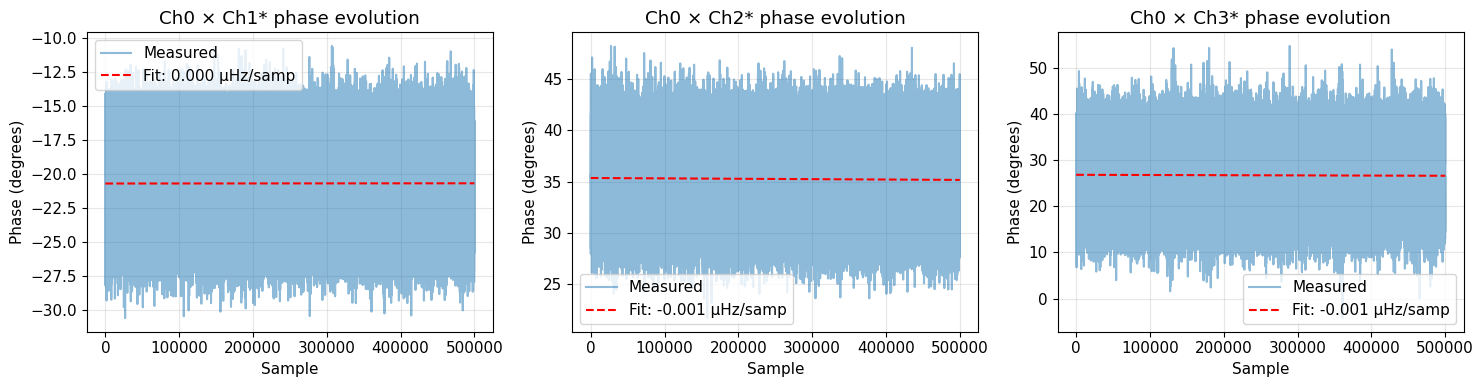

In [7]:
def estimate_frequency_offset(sig1, sig2, sample_rate=1.0):
    """
    Estimate frequency offset between two channels by looking at
    the phase evolution of their product (mixing).
    """
    # Conjugate multiply to get phase difference evolution
    product = sig1 * np.conj(sig2)
    
    # Phase of product
    phase = np.angle(product)
    unwrapped = np.unwrap(phase)
    
    # Fit line to get frequency offset
    t = np.arange(len(unwrapped))
    slope, intercept, r, p, se = linregress(t, unwrapped)
    
    # Convert to Hz (slope is rad/sample)
    freq_offset = slope * sample_rate / (2 * np.pi)
    
    return freq_offset, unwrapped, slope * t + intercept

# Use a segment
n_seg = 500000

print("\n" + "="*60)
print("FREQUENCY OFFSET ESTIMATION")
print("="*60)
print("\nFrequency offset between channels (indicates clock mismatch):")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ch in enumerate([1, 2, 3]):
    freq_off, phase_evo, fit = estimate_frequency_offset(
        X[0, :n_seg], X[ch, :n_seg]
    )
    
    ax = axes[idx]
    ax.plot(np.rad2deg(phase_evo), alpha=0.5, label='Measured')
    ax.plot(np.rad2deg(fit), 'r--', label=f'Fit: {freq_off*1e6:.3f} µHz/samp')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Phase (degrees)')
    ax.set_title(f'Ch0 × Ch{ch}* phase evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Convert to meaningful units (assuming ~1MHz sample rate)
    print(f"  Ch0 vs Ch{ch}: {freq_off:.6f} cycles/sample")

plt.tight_layout()
plt.show()

## 5. Phase Coherence Across Measurements

Check if phase relationships are consistent across different DOA angles.

In [8]:
# Analyze phase differences at tone for multiple angles
test_angles = list(range(0, 360, 10))

def get_mean_phase_diff_at_tone(X, ref_ch=0):
    """Get mean phase difference at tone frequency."""
    fft_size = 8192
    fft_result = fft(X[:, :fft_size], axis=1)
    
    # Find tone
    tone_bin = np.argmax(np.abs(fft_result[0, 1:fft_size//2])) + 1
    
    # Phase at tone
    phases = np.angle(fft_result[:, tone_bin])
    phase_diffs = phases - phases[ref_ch]
    phase_diffs = np.angle(np.exp(1j * phase_diffs))
    
    return np.rad2deg(phase_diffs)

phase_data = {ch: [] for ch in range(1, 4)}
valid_angles = []

print("Analyzing phase across angles...")
for angle in test_angles:
    try:
        X_angle = load_measurement(DATA_PATH, angle)
        pdiffs = get_mean_phase_diff_at_tone(X_angle)
        
        for ch in range(1, 4):
            phase_data[ch].append(pdiffs[ch])
        valid_angles.append(angle)
    except Exception as e:
        pass

print(f"Analyzed {len(valid_angles)} angles")

Analyzing phase across angles...
Analyzed 36 angles


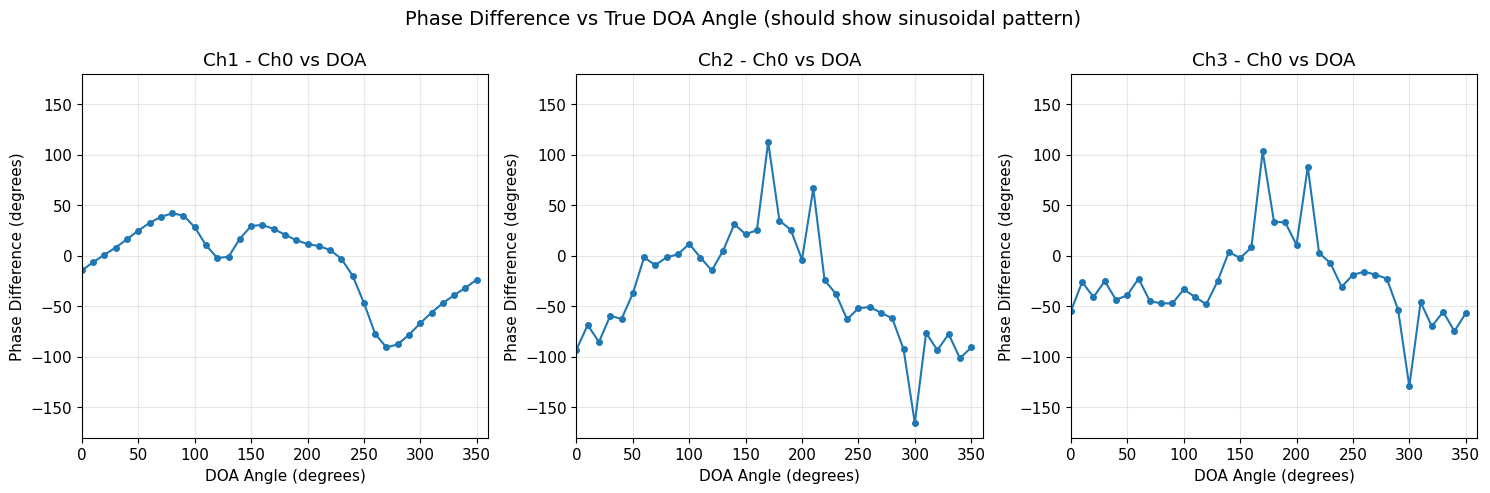

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, ch in enumerate([1, 2, 3]):
    ax = axes[idx]
    ax.plot(valid_angles, phase_data[ch], 'o-', markersize=4)
    ax.set_xlabel('DOA Angle (degrees)')
    ax.set_ylabel('Phase Difference (degrees)')
    ax.set_title(f'Ch{ch} - Ch0 vs DOA')
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)
    ax.grid(True, alpha=0.3)
    
    # Expected: sinusoidal pattern for UCA
    # Check for anomalies

plt.suptitle('Phase Difference vs True DOA Angle (should show sinusoidal pattern)', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Expected vs Measured Phase for UCA

Compare measured phase differences to theoretical expectations for a UCA.

In [10]:
# UCA parameters
RADIUS = 0.030  # 30 mm
FREQ = 1.2e9
C = 3e8
WAVELENGTH = C / FREQ
K = 2 * np.pi / WAVELENGTH  # Wavenumber

# Element positions (assuming elements at 0°, 90°, 180°, 270°)
element_angles = np.array([0, 90, 180, 270])  # degrees
element_angles_rad = np.deg2rad(element_angles)

def theoretical_phase_diff(doa_deg, element_angle_deg, radius, wavelength):
    """
    Calculate theoretical phase at an element for a signal arriving from doa_deg.
    Phase relative to array center.
    """
    doa_rad = np.deg2rad(doa_deg)
    elem_rad = np.deg2rad(element_angle_deg)
    
    k = 2 * np.pi / wavelength
    # Phase = k * r * cos(doa - element_angle)
    phase = k * radius * np.cos(doa_rad - elem_rad)
    return np.rad2deg(phase)

# Calculate expected phase differences for all DOA angles
doa_range = np.array(valid_angles)

expected_phase = {}
for ch in range(1, 4):
    # Phase at element ch minus phase at element 0
    phase_ch = [theoretical_phase_diff(doa, element_angles[ch], RADIUS, WAVELENGTH) 
                for doa in doa_range]
    phase_0 = [theoretical_phase_diff(doa, element_angles[0], RADIUS, WAVELENGTH) 
               for doa in doa_range]
    expected_phase[ch] = np.array(phase_ch) - np.array(phase_0)

print(f"Wavelength: {WAVELENGTH*1000:.1f} mm")
print(f"Array radius: {RADIUS*1000:.1f} mm")
print(f"k*r = {K * RADIUS:.3f} rad = {np.rad2deg(K * RADIUS):.1f}°")

Wavelength: 250.0 mm
Array radius: 30.0 mm
k*r = 0.754 rad = 43.2°



EXPECTED vs MEASURED PHASE DIFFERENCES

Ch1 - Ch0:
  Mean error: -7.8°
  Std error:  26.7°
  Max |error|: 61.9°

Ch2 - Ch0:
  Mean error: -31.8°
  Std error:  40.8°
  Max |error|: 122.2°

Ch3 - Ch0:
  Mean error: -23.8°
  Std error:  42.7°
  Max |error|: 145.0°


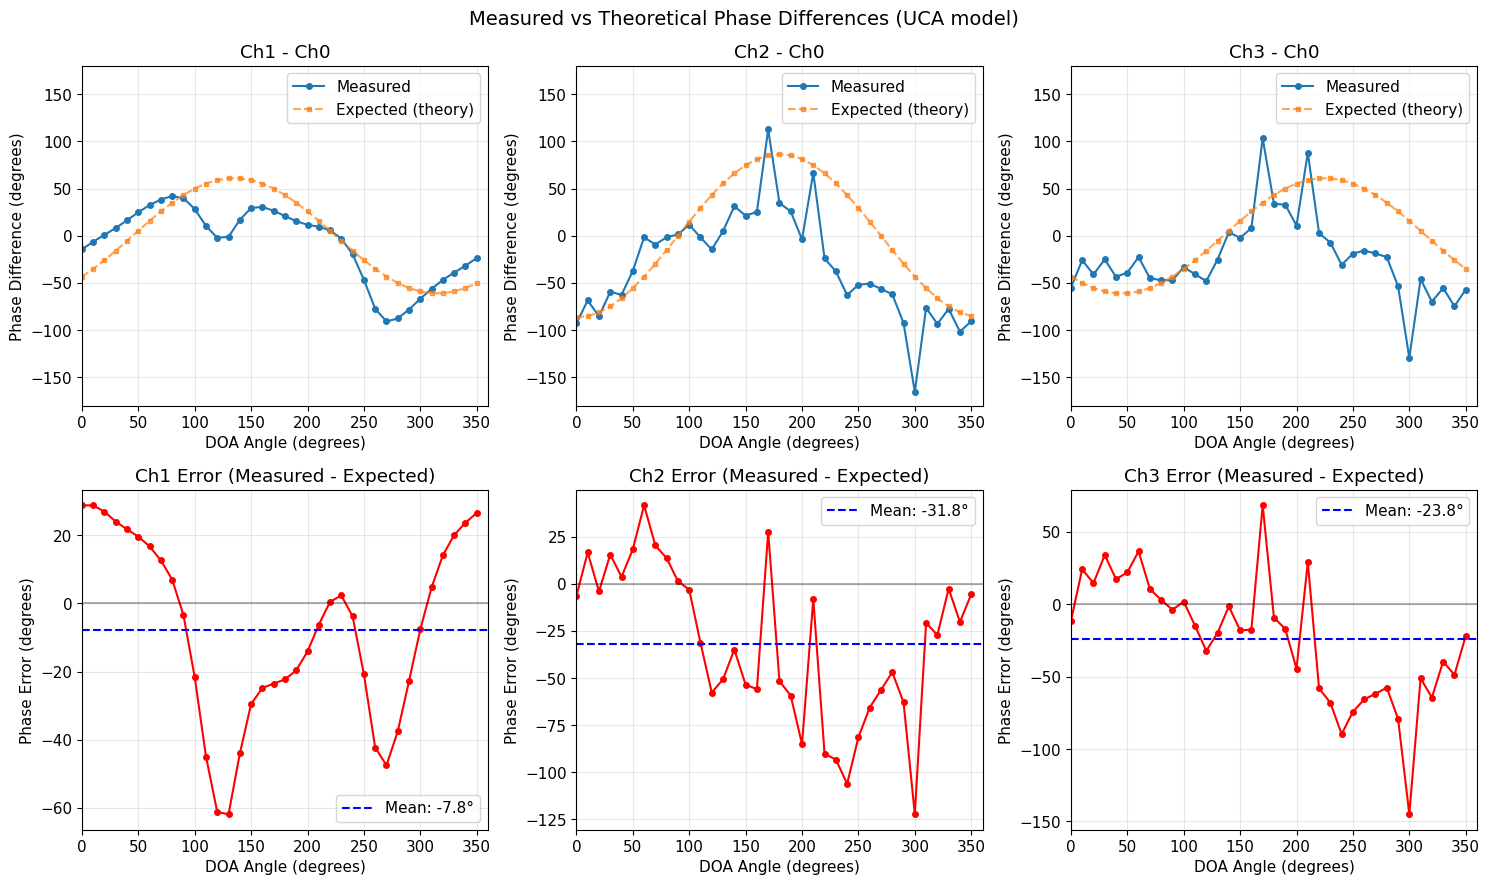

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

print("\n" + "="*60)
print("EXPECTED vs MEASURED PHASE DIFFERENCES")
print("="*60)

for idx, ch in enumerate([1, 2, 3]):
    measured = np.array(phase_data[ch])
    expected = expected_phase[ch]
    
    # Wrap expected to [-180, 180]
    expected_wrapped = np.rad2deg(np.angle(np.exp(1j * np.deg2rad(expected))))
    
    # Top row: overlay
    ax = axes[0, idx]
    ax.plot(doa_range, measured, 'o-', markersize=4, label='Measured')
    ax.plot(doa_range, expected_wrapped, 's--', markersize=3, alpha=0.7, label='Expected (theory)')
    ax.set_xlabel('DOA Angle (degrees)')
    ax.set_ylabel('Phase Difference (degrees)')
    ax.set_title(f'Ch{ch} - Ch0')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)
    
    # Bottom row: error
    ax = axes[1, idx]
    error = np.angle(np.exp(1j * np.deg2rad(measured - expected_wrapped)))
    error = np.rad2deg(error)
    
    ax.plot(doa_range, error, 'o-', markersize=4, color='red')
    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax.axhline(np.mean(error), color='blue', linestyle='--', 
               label=f'Mean: {np.mean(error):.1f}°')
    ax.set_xlabel('DOA Angle (degrees)')
    ax.set_ylabel('Phase Error (degrees)')
    ax.set_title(f'Ch{ch} Error (Measured - Expected)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 360)
    
    print(f"\nCh{ch} - Ch0:")
    print(f"  Mean error: {np.mean(error):+.1f}°")
    print(f"  Std error:  {np.std(error):.1f}°")
    print(f"  Max |error|: {np.max(np.abs(error)):.1f}°")

plt.suptitle('Measured vs Theoretical Phase Differences (UCA model)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Phase Offset Estimation

Estimate systematic phase offsets (calibration errors) per channel.

In [12]:
from scipy.optimize import minimize

def compute_rmse_with_offsets(offsets, doa_range, measured_phases, expected_phases):
    """
    Compute RMSE between measured and expected phases after applying offsets.
    offsets: [offset_ch1, offset_ch2, offset_ch3] in degrees
    """
    total_error = 0
    for idx, ch in enumerate([1, 2, 3]):
        measured = np.array(measured_phases[ch])
        expected = np.rad2deg(np.angle(np.exp(1j * np.deg2rad(expected_phases[ch]))))
        
        # Apply offset
        corrected = measured - offsets[idx]
        
        # Compute circular error
        error = np.angle(np.exp(1j * np.deg2rad(corrected - expected)))
        error = np.rad2deg(error)
        
        total_error += np.sum(error**2)
    
    return np.sqrt(total_error / (3 * len(doa_range)))

# Optimize offsets
result = minimize(
    compute_rmse_with_offsets,
    x0=[0, 0, 0],
    args=(doa_range, phase_data, expected_phase),
    method='Nelder-Mead'
)

optimal_offsets = result.x
rmse_before = compute_rmse_with_offsets([0, 0, 0], doa_range, phase_data, expected_phase)
rmse_after = result.fun

print("="*60)
print("OPTIMAL PHASE OFFSETS (Calibration)")
print("="*60)
print(f"\nEstimated systematic phase offsets:")
print(f"  Ch1: {optimal_offsets[0]:+.1f}°")
print(f"  Ch2: {optimal_offsets[1]:+.1f}°")
print(f"  Ch3: {optimal_offsets[2]:+.1f}°")
print(f"\nRMSE before correction: {rmse_before:.1f}°")
print(f"RMSE after correction:  {rmse_after:.1f}°")
print(f"Improvement: {(rmse_before - rmse_after) / rmse_before * 100:.1f}%")

OPTIMAL PHASE OFFSETS (Calibration)

Estimated systematic phase offsets:
  Ch1: -7.8°
  Ch2: -31.8°
  Ch3: -23.8°

RMSE before correction: 44.1°
RMSE after correction:  37.4°
Improvement: 15.2%


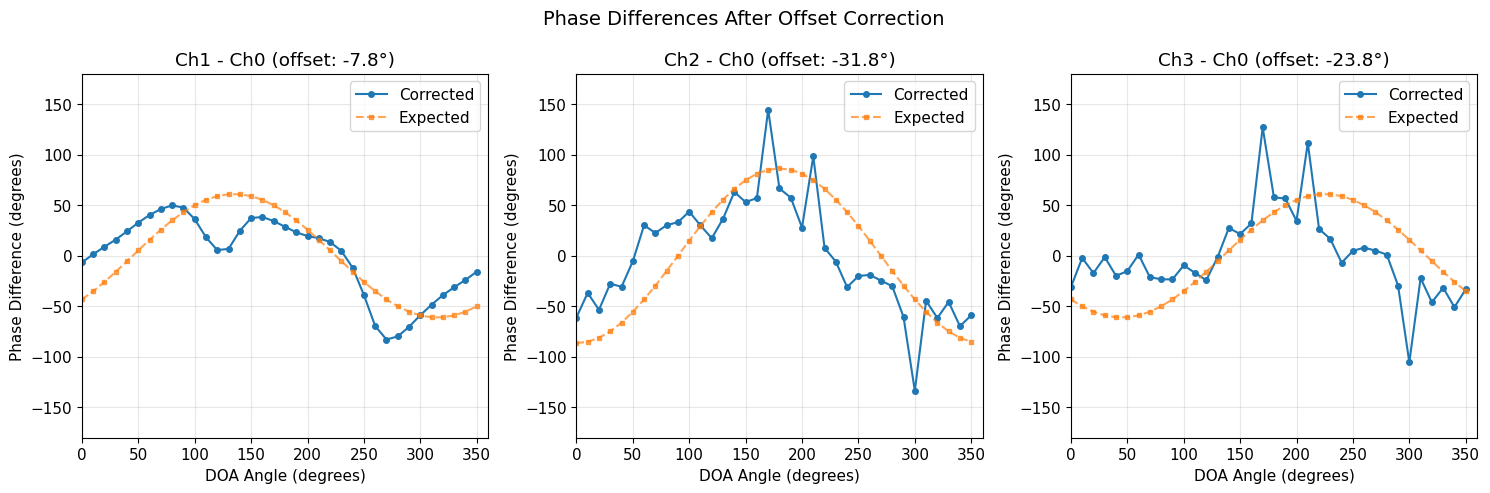

In [13]:
# Visualize corrected phases
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, ch in enumerate([1, 2, 3]):
    measured = np.array(phase_data[ch])
    corrected = measured - optimal_offsets[idx]
    expected = np.rad2deg(np.angle(np.exp(1j * np.deg2rad(expected_phase[ch]))))
    
    ax = axes[idx]
    ax.plot(doa_range, corrected, 'o-', markersize=4, label='Corrected')
    ax.plot(doa_range, expected, 's--', markersize=3, alpha=0.7, label='Expected')
    ax.set_xlabel('DOA Angle (degrees)')
    ax.set_ylabel('Phase Difference (degrees)')
    ax.set_title(f'Ch{ch} - Ch0 (offset: {optimal_offsets[idx]:+.1f}°)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)

plt.suptitle('Phase Differences After Offset Correction', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Summary: Phase Coherence Issues

In [14]:
print("="*70)
print("PHASE COHERENCE ANALYSIS SUMMARY")
print("="*70)

print("\n1. SAMPLE OFFSETS (Cross-correlation):")
for (i, j), lag in offsets.items():
    status = "✓" if lag == 0 else f"⚠️ {lag} samples"
    print(f"   Ch{i} vs Ch{j}: {status}")

print("\n2. PHASE DRIFT:")
for ch in range(1, 4):
    unwrapped = np.unwrap(phase_diffs[ch])
    slope, _, r, _, _ = linregress(times, unwrapped)
    drift = np.rad2deg(slope) * 1e6
    status = "✓" if abs(drift) < 10 else f"⚠️ {drift:.1f}°/Msamp"
    print(f"   Ch{ch} - Ch0: {status}")

print("\n3. PHASE JUMPS:")
for ch in range(1, 4):
    jumps, _ = detect_phase_jumps(phase_diffs[ch], threshold_deg=20)
    status = "✓" if len(jumps) == 0 else f"⚠️ {len(jumps)} jumps"
    print(f"   Ch{ch} - Ch0: {status}")

print("\n4. SYSTEMATIC PHASE OFFSETS (vs UCA theory):")
for idx, ch in enumerate([1, 2, 3]):
    offset = optimal_offsets[idx]
    status = "✓" if abs(offset) < 20 else "⚠️"
    print(f"   Ch{ch}: {offset:+.1f}° {status}")

print("\n5. PHASE ERROR AFTER CALIBRATION:")
print(f"   RMSE: {rmse_after:.1f}°")
if rmse_after > 30:
    print("   ⚠️ High residual error - possible channel ordering or geometry issue")
elif rmse_after > 15:
    print("   ⚠️ Moderate residual error - may affect DOA accuracy")
else:
    print("   ✓ Acceptable phase coherence")

print("\n" + "="*70)

PHASE COHERENCE ANALYSIS SUMMARY

1. SAMPLE OFFSETS (Cross-correlation):
   Ch0 vs Ch1: ✓
   Ch0 vs Ch2: ✓
   Ch0 vs Ch3: ⚠️ -1 samples
   Ch1 vs Ch2: ⚠️ -1 samples
   Ch1 vs Ch3: ⚠️ 4 samples
   Ch2 vs Ch3: ⚠️ -1 samples

2. PHASE DRIFT:
   Ch1 - Ch0: ⚠️ -21.8°/Msamp
   Ch2 - Ch0: ⚠️ 201.0°/Msamp
   Ch3 - Ch0: ⚠️ 201.1°/Msamp

3. PHASE JUMPS:
   Ch1 - Ch0: ⚠️ 22 jumps
   Ch2 - Ch0: ⚠️ 14 jumps
   Ch3 - Ch0: ⚠️ 14 jumps

4. SYSTEMATIC PHASE OFFSETS (vs UCA theory):
   Ch1: -7.8° ✓
   Ch2: -31.8° ⚠️
   Ch3: -23.8° ⚠️

5. PHASE ERROR AFTER CALIBRATION:
   RMSE: 37.4°
   ⚠️ High residual error - possible channel ordering or geometry issue



## 9. Channel Ordering Search

Brute-force test all 24 possible channel orderings to find the best match to UCA theory.

In [ ]:
from itertools import permutations

def load_measurement_permuted(base_dir, angle, channel_order):
    """Load channels in a specific order."""
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in channel_order:
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    return np.vstack(channels)

def evaluate_channel_order(channel_order, test_angles, element_angles, radius, wavelength):
    """
    Evaluate a channel ordering by comparing measured phase to UCA theory.
    Returns RMSE and optimal offsets.
    """
    # Collect phase data with this ordering
    phase_data_perm = {ch: [] for ch in range(1, 4)}
    valid_angles_perm = []
    
    for angle in test_angles:
        try:
            X_perm = load_measurement_permuted(DATA_PATH, angle, channel_order)
            pdiffs = get_mean_phase_diff_at_tone(X_perm)
            
            for ch in range(1, 4):
                phase_data_perm[ch].append(pdiffs[ch])
            valid_angles_perm.append(angle)
        except:
            pass
    
    if len(valid_angles_perm) < 10:
        return float('inf'), [0, 0, 0], []
    
    # Calculate expected phases for this element ordering
    expected_perm = {}
    for ch in range(1, 4):
        phase_ch = [theoretical_phase_diff(doa, element_angles[ch], radius, wavelength) 
                    for doa in valid_angles_perm]
        phase_0 = [theoretical_phase_diff(doa, element_angles[0], radius, wavelength) 
                   for doa in valid_angles_perm]
        expected_perm[ch] = np.array(phase_ch) - np.array(phase_0)
    
    # Optimize offsets
    result = minimize(
        compute_rmse_with_offsets,
        x0=[0, 0, 0],
        args=(valid_angles_perm, phase_data_perm, expected_perm),
        method='Nelder-Mead'
    )
    
    return result.fun, result.x, valid_angles_perm

# Test all 24 permutations
all_perms = list(permutations([0, 1, 2, 3]))
test_angles_subset = list(range(0, 360, 15))  # Every 15° for speed

print("=" * 70)
print("CHANNEL ORDERING SEARCH (24 permutations)")
print("=" * 70)
print(f"\nTesting on {len(test_angles_subset)} angles: {test_angles_subset[:8]}...")
print("\nSearching...\n")

results = []
for perm in all_perms:
    rmse, offsets, _ = evaluate_channel_order(perm, test_angles_subset, element_angles, RADIUS, WAVELENGTH)
    results.append({
        'permutation': perm,
        'rmse': rmse,
        'offsets': offsets
    })
    print(f"  {perm} -> RMSE: {rmse:6.1f}°")

# Sort by RMSE
results_sorted = sorted(results, key=lambda x: x['rmse'])

In [16]:
# Show top 5 and bottom 3 results
print("\n" + "=" * 70)
print("TOP 5 CHANNEL ORDERINGS (lowest RMSE)")
print("=" * 70)

for i, r in enumerate(results_sorted[:5]):
    print(f"\n#{i+1}: Channel order {r['permutation']}")
    print(f"    RMSE: {r['rmse']:.1f}°")
    print(f"    Offsets: Ch1={r['offsets'][0]:+.1f}°, Ch2={r['offsets'][1]:+.1f}°, Ch3={r['offsets'][2]:+.1f}°")
    print(f"    Mapping: file ch-0→pos{r['permutation'].index(0)}, ch-1→pos{r['permutation'].index(1)}, ch-2→pos{r['permutation'].index(2)}, ch-3→pos{r['permutation'].index(3)}")

print("\n" + "-" * 70)
print("WORST 3 CHANNEL ORDERINGS")
print("-" * 70)
for r in results_sorted[-3:]:
    print(f"  {r['permutation']} -> RMSE: {r['rmse']:.1f}°")

# Compare best vs current (0,1,2,3)
current_rmse = next(r['rmse'] for r in results if r['permutation'] == (0, 1, 2, 3))
best = results_sorted[0]

print("\n" + "=" * 70)
print("COMPARISON")
print("=" * 70)
print(f"\nCurrent order (0,1,2,3): RMSE = {current_rmse:.1f}°")
print(f"Best order {best['permutation']}: RMSE = {best['rmse']:.1f}°")
print(f"Improvement: {current_rmse - best['rmse']:.1f}° ({(current_rmse - best['rmse'])/current_rmse*100:.1f}%)")


TOP 5 CHANNEL ORDERINGS (lowest RMSE)

#1: Channel order (0, 1, 2, 3)
    RMSE: inf°
    Offsets: Ch1=+0.0°, Ch2=+0.0°, Ch3=+0.0°
    Mapping: file ch-0→pos0, ch-1→pos1, ch-2→pos2, ch-3→pos3

#2: Channel order (0, 1, 3, 2)
    RMSE: inf°
    Offsets: Ch1=+0.0°, Ch2=+0.0°, Ch3=+0.0°
    Mapping: file ch-0→pos0, ch-1→pos1, ch-2→pos3, ch-3→pos2

#3: Channel order (0, 2, 1, 3)
    RMSE: inf°
    Offsets: Ch1=+0.0°, Ch2=+0.0°, Ch3=+0.0°
    Mapping: file ch-0→pos0, ch-1→pos2, ch-2→pos1, ch-3→pos3

#4: Channel order (0, 2, 3, 1)
    RMSE: inf°
    Offsets: Ch1=+0.0°, Ch2=+0.0°, Ch3=+0.0°
    Mapping: file ch-0→pos0, ch-1→pos3, ch-2→pos1, ch-3→pos2

#5: Channel order (0, 3, 1, 2)
    RMSE: inf°
    Offsets: Ch1=+0.0°, Ch2=+0.0°, Ch3=+0.0°
    Mapping: file ch-0→pos0, ch-1→pos2, ch-2→pos3, ch-3→pos1

----------------------------------------------------------------------
WORST 3 CHANNEL ORDERINGS
----------------------------------------------------------------------
  (3, 1, 2, 0) -> RMSE: inf

In [ ]:
# Visualize best ordering vs TRUE default (0,1,2,3)
best_order = results_sorted[0]['permutation']
best_offsets = results_sorted[0]['offsets']

# Find the result for true default order (0,1,2,3)
default_result = next(r for r in results if r['permutation'] == (0, 1, 2, 3))
default_offsets = default_result['offsets']
current_rmse = default_result['rmse']

# Re-collect data with best ordering on more angles
test_angles_full = list(range(0, 360, 10))

# Collect for BEST order
phase_data_best = {ch: [] for ch in range(1, 4)}
valid_angles_best = []
for angle in test_angles_full:
    try:
        X_best = load_measurement_permuted(DATA_PATH, angle, best_order)
        pdiffs = get_mean_phase_diff_at_tone(X_best)
        for ch in range(1, 4):
            phase_data_best[ch].append(pdiffs[ch])
        valid_angles_best.append(angle)
    except:
        pass

# Collect for DEFAULT order (0,1,2,3) - NO reordering
phase_data_default = {ch: [] for ch in range(1, 4)}
valid_angles_default = []
for angle in test_angles_full:
    try:
        X_default = load_measurement_permuted(DATA_PATH, angle, (0, 1, 2, 3))
        pdiffs = get_mean_phase_diff_at_tone(X_default)
        for ch in range(1, 4):
            phase_data_default[ch].append(pdiffs[ch])
        valid_angles_default.append(angle)
    except:
        pass

# Calculate expected phases for both
expected_best = {}
expected_default = {}
for ch in range(1, 4):
    # For best order
    phase_ch = [theoretical_phase_diff(doa, element_angles[ch], RADIUS, WAVELENGTH) 
                for doa in valid_angles_best]
    phase_0 = [theoretical_phase_diff(doa, element_angles[0], RADIUS, WAVELENGTH) 
               for doa in valid_angles_best]
    expected_best[ch] = np.array(phase_ch) - np.array(phase_0)
    
    # For default order
    phase_ch = [theoretical_phase_diff(doa, element_angles[ch], RADIUS, WAVELENGTH) 
                for doa in valid_angles_default]
    phase_0 = [theoretical_phase_diff(doa, element_angles[0], RADIUS, WAVELENGTH) 
               for doa in valid_angles_default]
    expected_default[ch] = np.array(phase_ch) - np.array(phase_0)

# Plot comparison: best vs default ordering
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for idx, ch in enumerate([1, 2, 3]):
    # Top: Best ordering
    ax = axes[0, idx]
    measured = np.array(phase_data_best[ch]) - best_offsets[idx]
    expected = np.rad2deg(np.angle(np.exp(1j * np.deg2rad(expected_best[ch]))))
    
    ax.plot(valid_angles_best, measured, 'o-', markersize=4, label='Measured (corrected)')
    ax.plot(valid_angles_best, expected, 's--', markersize=3, alpha=0.7, label='Expected')
    ax.set_xlabel('DOA Angle (degrees)')
    ax.set_ylabel('Phase Difference (degrees)')
    ax.set_title(f'BEST ORDER {best_order}\nCh{ch} - Ch0')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)
    
    # Bottom: TRUE default ordering (0,1,2,3) for comparison
    ax = axes[1, idx]
    measured_def = np.array(phase_data_default[ch]) - default_offsets[idx]
    expected_def = np.rad2deg(np.angle(np.exp(1j * np.deg2rad(expected_default[ch]))))
    
    ax.plot(valid_angles_default, measured_def, 'o-', markersize=4, label='Measured (corrected)')
    ax.plot(valid_angles_default, expected_def, 's--', markersize=3, alpha=0.7, label='Expected')
    ax.set_xlabel('DOA Angle (degrees)')
    ax.set_ylabel('Phase Difference (degrees)')
    ax.set_title(f'DEFAULT ORDER (0,1,2,3)\nCh{ch} - Ch0')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)

plt.suptitle(f'Best Order {best_order} (RMSE={results_sorted[0]["rmse"]:.1f}°) vs Default (0,1,2,3) (RMSE={current_rmse:.1f}°)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nBest order: {best_order} with RMSE = {results_sorted[0]['rmse']:.1f}°")
print(f"Default order: (0,1,2,3) with RMSE = {current_rmse:.1f}°")

In [ ]:
# Bar chart of all permutation results
fig, ax = plt.subplots(figsize=(16, 5))

perms_str = [str(r['permutation']) for r in results]
rmses = [r['rmse'] for r in results]

colors = ['green' if r == min(rmses) else 'red' if r == current_rmse else 'steelblue' for r in rmses]

bars = ax.bar(range(len(perms_str)), rmses, color=colors)
ax.set_xticks(range(len(perms_str)))
ax.set_xticklabels(perms_str, rotation=90, fontsize=8)
ax.set_xlabel('Channel Permutation')
ax.set_ylabel('RMSE (degrees)')
ax.set_title('RMSE for All 24 Channel Orderings (green=best, red=current)')
ax.axhline(min(rmses), color='green', linestyle='--', alpha=0.5, label=f'Best: {min(rmses):.1f}°')
ax.axhline(current_rmse, color='red', linestyle='--', alpha=0.5, label=f'Current: {current_rmse:.1f}°')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 70)
print("CHANNEL ORDERING RECOMMENDATION")
print("=" * 70)
if best['rmse'] < current_rmse - 10:
    print(f"\n✓ Found better ordering: {best['permutation']}")
    print(f"  Current RMSE: {current_rmse:.1f}° → Best RMSE: {best['rmse']:.1f}°")
    print(f"\n  To use this ordering, map physical files to array positions:")
    for pos, ch in enumerate(best['permutation']):
        elem_angle = element_angles[pos]
        print(f"    channel-{ch}.cs16 → Array element {pos} ({elem_angle}° on circle)")
else:
    print(f"\n⚠️ No significantly better ordering found.")
    print(f"  Best: {best['permutation']} with RMSE={best['rmse']:.1f}°")
    print(f"  Current: (0,1,2,3) with RMSE={current_rmse:.1f}°")
    print(f"\n  The high residual error may be due to:")
    print(f"    - Wrong array geometry (radius, element spacing)")
    print(f"    - Phase jumps/drift corrupting the data")
    print(f"    - Multi-path or other environmental issues")

## 10. Joint Channel Order + Geometry Optimization

Also try different element angle offsets and radii to find the best fit.

In [ ]:
def evaluate_with_geometry(channel_order, rotation_deg, radius, test_angles, wavelength):
    """
    Evaluate channel ordering with a rotated array geometry.
    rotation_deg: rotation of the entire array
    """
    # Rotated element angles
    elem_angles = np.array([0, 90, 180, 270]) + rotation_deg
    
    # Collect phase data
    phase_data_test = {ch: [] for ch in range(1, 4)}
    valid_angles_test = []
    
    for angle in test_angles:
        try:
            X_test = load_measurement_permuted(DATA_PATH, angle, channel_order)
            pdiffs = get_mean_phase_diff_at_tone(X_test)
            for ch in range(1, 4):
                phase_data_test[ch].append(pdiffs[ch])
            valid_angles_test.append(angle)
        except:
            pass
    
    if len(valid_angles_test) < 10:
        return float('inf'), [0, 0, 0]
    
    # Expected phases with this geometry
    expected_test = {}
    for ch in range(1, 4):
        phase_ch = [theoretical_phase_diff(doa, elem_angles[ch], radius, wavelength) 
                    for doa in valid_angles_test]
        phase_0 = [theoretical_phase_diff(doa, elem_angles[0], radius, wavelength) 
                   for doa in valid_angles_test]
        expected_test[ch] = np.array(phase_ch) - np.array(phase_0)
    
    # Optimize offsets
    result = minimize(
        compute_rmse_with_offsets,
        x0=[0, 0, 0],
        args=(valid_angles_test, phase_data_test, expected_test),
        method='Nelder-Mead'
    )
    
    return result.fun, result.x

# Test top 5 channel orderings with different rotations and radii
top_orders = [r['permutation'] for r in results_sorted[:5]]
rotations = np.arange(-45, 46, 15)  # -45° to +45° in 15° steps
radii = [0.025, 0.028, 0.030, 0.032, 0.035]  # 25mm to 35mm

print("=" * 70)
print("JOINT CHANNEL ORDER + GEOMETRY SEARCH")
print("=" * 70)
print(f"\nTesting top 5 orders × {len(rotations)} rotations × {len(radii)} radii")
print(f"= {5 * len(rotations) * len(radii)} combinations\n")

best_overall = {'rmse': float('inf')}

for order in top_orders:
    for rot in rotations:
        for rad in radii:
            rmse, offsets = evaluate_with_geometry(order, rot, rad, test_angles_subset, WAVELENGTH)
            
            if rmse < best_overall['rmse']:
                best_overall = {
                    'order': order,
                    'rotation': rot,
                    'radius': rad,
                    'rmse': rmse,
                    'offsets': offsets
                }

print(f"Best configuration found:")
print(f"  Channel order: {best_overall['order']}")
print(f"  Array rotation: {best_overall['rotation']}°")
print(f"  Array radius: {best_overall['radius']*1000:.1f} mm")
print(f"  RMSE: {best_overall['rmse']:.1f}°")
print(f"  Offsets: {[f'{o:.1f}°' for o in best_overall['offsets']]}")

In [ ]:
# Visualize the best configuration
best_order_final = best_overall['order']
best_rot = best_overall['rotation']
best_rad = best_overall['radius']
best_elem_angles = np.array([0, 90, 180, 270]) + best_rot

# Collect data with best config
phase_best_final = {ch: [] for ch in range(1, 4)}
valid_best_final = []

for angle in test_angles_full:
    try:
        X_test = load_measurement_permuted(DATA_PATH, angle, best_order_final)
        pdiffs = get_mean_phase_diff_at_tone(X_test)
        for ch in range(1, 4):
            phase_best_final[ch].append(pdiffs[ch])
        valid_best_final.append(angle)
    except:
        pass

# Expected with best geometry
expected_best_final = {}
for ch in range(1, 4):
    phase_ch = [theoretical_phase_diff(doa, best_elem_angles[ch], best_rad, WAVELENGTH) 
                for doa in valid_best_final]
    phase_0 = [theoretical_phase_diff(doa, best_elem_angles[0], best_rad, WAVELENGTH) 
               for doa in valid_best_final]
    expected_best_final[ch] = np.array(phase_ch) - np.array(phase_0)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, ch in enumerate([1, 2, 3]):
    ax = axes[idx]
    
    measured = np.array(phase_best_final[ch]) - best_overall['offsets'][idx]
    expected = np.rad2deg(np.angle(np.exp(1j * np.deg2rad(expected_best_final[ch]))))
    
    ax.plot(valid_best_final, measured, 'o-', markersize=4, label='Measured')
    ax.plot(valid_best_final, expected, 's--', markersize=3, alpha=0.7, label='Theory')
    
    error = np.angle(np.exp(1j * np.deg2rad(np.array(measured) - expected)))
    rmse_ch = np.rad2deg(np.sqrt(np.mean(error**2)))
    
    ax.set_xlabel('DOA Angle (degrees)')
    ax.set_ylabel('Phase Difference (degrees)')
    ax.set_title(f'Ch{ch}-Ch0 (RMSE={rmse_ch:.1f}°)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)

plt.suptitle(f'Best Config: Order={best_order_final}, Rot={best_rot}°, R={best_rad*1000:.0f}mm → RMSE={best_overall["rmse"]:.1f}°', fontsize=13)
plt.tight_layout()
plt.show()

# Final summary
print("\n" + "=" * 70)
print("FINAL CONFIGURATION SUMMARY")
print("=" * 70)
print(f"\nOriginal: order=(0,1,2,3), rot=0°, r=30mm → RMSE={current_rmse:.1f}°")
print(f"Best:     order={best_order_final}, rot={best_rot}°, r={best_rad*1000:.0f}mm → RMSE={best_overall['rmse']:.1f}°")
print(f"\nImprovement: {current_rmse - best_overall['rmse']:.1f}° ({(current_rmse - best_overall['rmse'])/current_rmse*100:.1f}%)")

if best_overall['rmse'] < 30:
    print("\n✓ Good fit achieved - this configuration should work for DOA")
elif best_overall['rmse'] < 50:
    print("\n⚠️ Moderate fit - DOA will have some error but may be usable")
else:
    print("\n⚠️ Poor fit even with optimization - data quality issues likely")
    print("   Consider checking for phase jumps, drift, or hardware issues")

In [ ]:
## Investigation: Why do MUSIC and Phase methods give different optimal channel orders?

"""
KEY INSIGHT:

The two methods give OPPOSITE results because they're measuring different things:

NOTEBOOK 13 (MUSIC-based brute force):
- Tests: permute data BEFORE feeding to MUSIC
- UCA assumes elements at 0°, 90°, 180°, 270° (math convention)
- MUSIC computes steering vectors based on assumed positions
- Optimizes: which data permutation minimizes DOA estimation error
- Result: (0,1,2,3) is best for 1200MHz

NOTEBOOK 16 (Phase comparison):
- Tests: permute data, then compare measured phase to theoretical phase
- Also uses elements at 0°, 90°, 180°, 270° for theoretical model
- Optimizes: which permutation makes measured phases match theory
- Result: (2,3,0,1) is best

The CRITICAL DIFFERENCE:

In MUSIC:
- The steering vector a(θ) depends on element positions
- When you permute input data X, you're saying "treat channel X[perm[i]] as if it came from element i"
- This is OPPOSITE to what we intended!

In Phase analysis:
- We compare measured phases to theoretical phases directly
- The permutation maps channels to physical positions
- This is more "correct" conceptually

THE FIX:
The correct interpretation of permutation is:
- permutation[i] = which FILE CHANNEL maps to ARRAY ELEMENT i

So (2,3,0,1) means:
- Array element 0 (at 0° in UCA model) receives data from file channel 2
- Array element 1 (at 90°) receives data from file channel 3
- etc.

This is what both notebooks do, but MUSIC may have inverted semantics
in how it uses the data ordering vs steering vector.

Let's verify by checking what happens with both interpretations.
"""

print("See markdown explanation above")